In [11]:
# import os
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from torchinfo import summary
from torch.utils.data import DataLoader

from models.deepLOB.deepLOB_model import Deeplob
from models.transLOB import TransLOB
from utils.fi2010_loader import load_fi2010
from utils.training import train_validate
from utils.evaluation import evaluate
from utils.plots import plot_training_history, plot_label_distributions

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
dataset_type='fi2010'
normalization = 'DecPre'
lighten = False
feature_size = 40

T = 100
k = 4
stock = [0, 1, 2, 3, 4]
train_val_ratio = 0.8

train_days = [7]
test_days = [8,9,10]

batch_size= 128
num_workers= 4

In [11]:
dataset_train, dataset_val, dataset_test = load_fi2010(train_val_ratio, normalization, stock, 
                                                       train_days, test_days, T, k, True)

print(f"Training Data Size : {dataset_train.__len__()}")
print(f"Validation Data Size : {dataset_val.__len__()}")
print(f"Test Data Size : {dataset_test.__len__()}")

train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)#, num_workers=num_workers)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)#, num_workers=num_workers)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)#, num_workers=num_workers)

Loading:  Train_Dst_NoAuction_ZScore_CF_7.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_7.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_8.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_9.txt
Training Data Size : 203404
Validation Data Size : 50851
Test Data Size : 138102


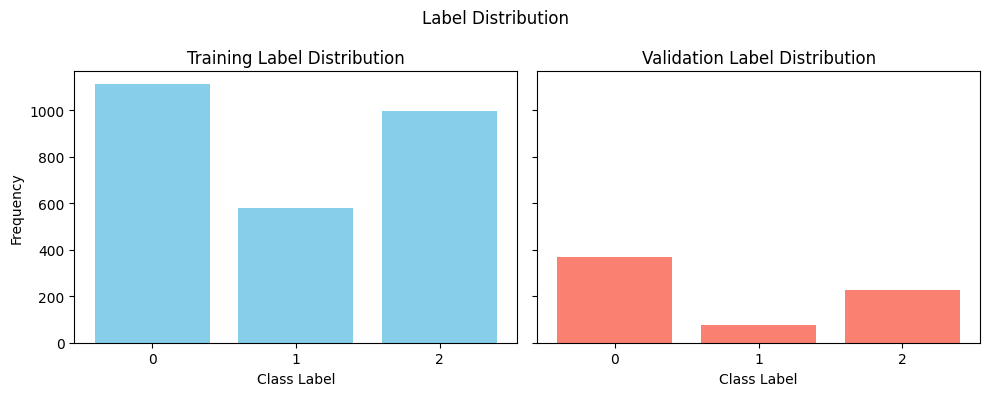

In [7]:
plot_label_distributions(dataset_train, dataset_val)

# DeepLOB

In [6]:
model_deepLOB = Deeplob().to(device)
summary(model_deepLOB, (1, 1, 100, feature_size))

Layer (type:depth-idx)                   Output Shape              Param #
Deeplob                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [7]:
epochs = 50
learning_rate = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deepLOB.parameters(), lr=learning_rate)

history = train_validate(model_deepLOB, train_loader, val_loader, optimizer, criterion, epochs, normalization, k, dataset_type, device)

Epoch 1/50, Train Loss: 1.0278, Train Acc: 0.4753, Validation Loss: 0.9934, Validation Acc: 0.5219
Epoch 2/50, Train Loss: 0.8933, Train Acc: 0.6422, Validation Loss: 0.9600, Validation Acc: 0.5643
Epoch 3/50, Train Loss: 0.8471, Train Acc: 0.6917, Validation Loss: 0.9466, Validation Acc: 0.5806
Epoch 4/50, Train Loss: 0.8271, Train Acc: 0.7135, Validation Loss: 0.9278, Validation Acc: 0.6022
Epoch 5/50, Train Loss: 0.8136, Train Acc: 0.7286, Validation Loss: 0.9275, Validation Acc: 0.6034
Epoch 6/50, Train Loss: 0.8049, Train Acc: 0.7379, Validation Loss: 0.9322, Validation Acc: 0.5974
Epoch 7/50, Train Loss: 0.7972, Train Acc: 0.7466, Validation Loss: 0.9173, Validation Acc: 0.6147
Epoch 8/50, Train Loss: 0.7905, Train Acc: 0.7532, Validation Loss: 0.9238, Validation Acc: 0.6094
Epoch 9/50, Train Loss: 0.7839, Train Acc: 0.7613, Validation Loss: 0.9152, Validation Acc: 0.6196
Epoch 10/50, Train Loss: 0.7791, Train Acc: 0.7662, Validation Loss: 0.9148, Validation Acc: 0.6185
Epoch 11/

KeyboardInterrupt: 

In [ ]:
plot_training_history(history)

In [ ]:
evaluate(model_deepLOB, test_loader, device)

In [ ]:
# from utils.fi2010_loader import __vis_sample_lob__
# __vis_sample_lob__('DecPre')

In [12]:
# epochs = 30
# learning_rate = 1e-4

# for normalization in ['DecPre','Zscore','MinMax']:
#     for k in [4]: #[0,1,2,3,4]:
#         dataset_train, dataset_val, dataset_test = load_fi2010(train_val_ratio, normalization, stock, 
#                                                            train_days, test_days, T, k, True)
#         if k==4:
#             print(f"Training Data Size : {dataset_train.__len__()}")
#             print(f"Validation Data Size : {dataset_val.__len__()}")
#             print(f"Test Data Size : {dataset_test.__len__()}")
        
#         train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
#         val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False, num_workers=num_workers)
#         test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#         model_deepLOB = Deeplob().to(device)
        
#         criterion = nn.CrossEntropyLoss()
#         optimizer = torch.optim.Adam(model_deepLOB.parameters(), lr=learning_rate)

#         history = train_validate(model_deepLOB, train_loader, val_loader, optimizer, criterion, epochs, normalization, k, dataset_type, device)

Loading:  Train_Dst_NoAuction_DecPre_CF_7.txt
Loading:  Test_Dst_NoAuction_DecPre_CF_7.txt
Loading:  Test_Dst_NoAuction_DecPre_CF_8.txt
Loading:  Test_Dst_NoAuction_DecPre_CF_9.txt
Training Data Size : 203404
Validation Data Size : 50851
Test Data Size : 138102
Epoch 1/30, Train Loss: 0.9478, Train Acc: 0.5754, Validation Loss: 1.0651, Validation Acc: 0.4427
Epoch 2/30, Train Loss: 0.8566, Train Acc: 0.6819, Validation Loss: 1.1469, Validation Acc: 0.3670
Epoch 3/30, Train Loss: 0.8215, Train Acc: 0.7192, Validation Loss: 0.9978, Validation Acc: 0.5226
Epoch 4/30, Train Loss: 0.8012, Train Acc: 0.7417, Validation Loss: 0.9975, Validation Acc: 0.5242
Epoch 5/30, Train Loss: 0.7874, Train Acc: 0.7563, Validation Loss: 0.9454, Validation Acc: 0.5857
Epoch 6/30, Train Loss: 0.7781, Train Acc: 0.7657, Validation Loss: 0.9575, Validation Acc: 0.5737
Epoch 7/30, Train Loss: 0.7677, Train Acc: 0.7773, Validation Loss: 0.9994, Validation Acc: 0.5252
Epoch 8/30, Train Loss: 0.7599, Train Acc: 0.

KeyboardInterrupt: 

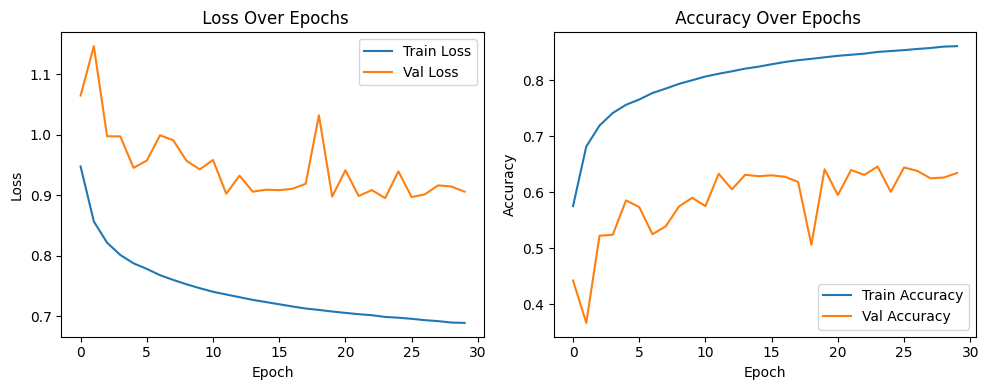

In [13]:
plot_training_history(history)

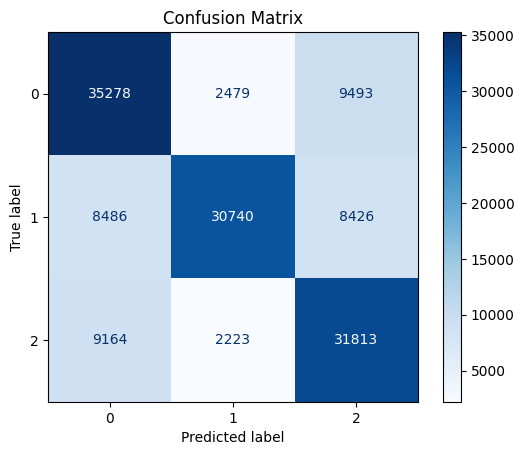

              precision    recall  f1-score   support

           0     0.6665    0.7466    0.7043     47250
           1     0.8673    0.6451    0.7399     47652
           2     0.6397    0.7364    0.6847     43200

    accuracy                         0.7084    138102
   macro avg     0.7245    0.7094    0.7096    138102
weighted avg     0.7274    0.7084    0.7104    138102

Test Accuracy: 0.7084
Test Precision (macro): 0.7245
Test Recall (macro): 0.7094
Test F1 Score (macro): 0.7096


In [15]:
evaluate(model_deepLOB, test_loader, device)

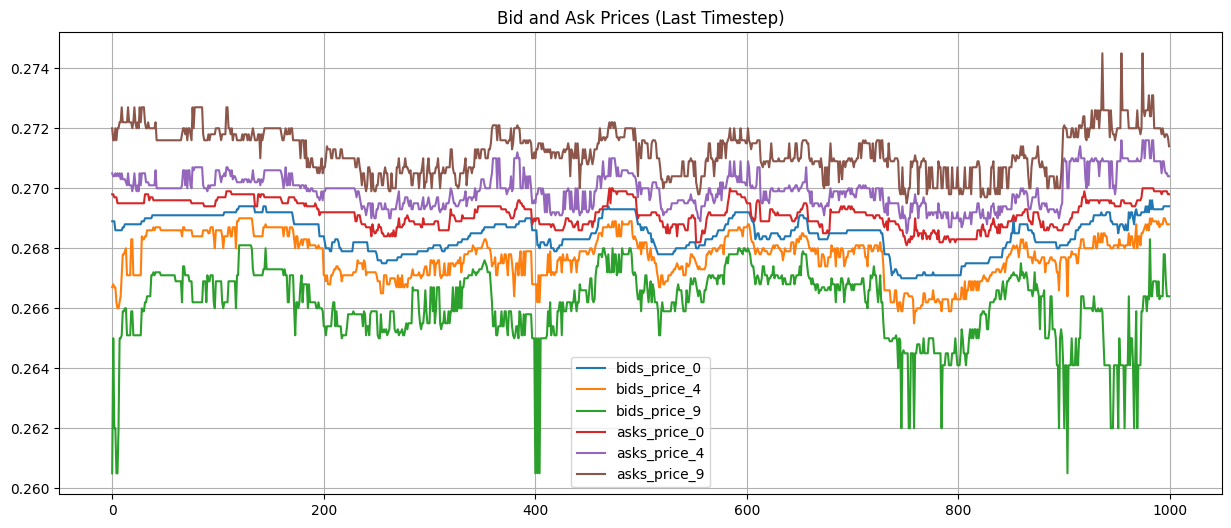

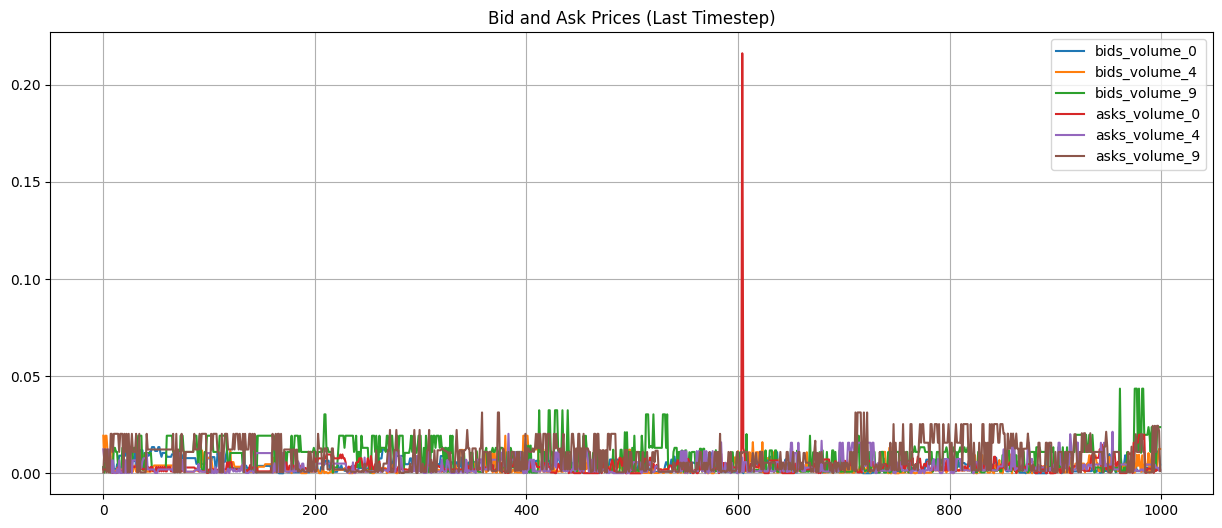

In [61]:
s = 7000
l = 1000

X_sample, y_sample = dataset_train[s:s+l]  # or use `next(iter(train_loader))` for a batch
# Assuming X_sample has shape (plot_range, 100, 40)
# Flatten or average over time if needed
X_plot = X_sample[:, -1, :]  # last time step
df_plot = pd.DataFrame(X_plot.numpy(), columns=[f'feature_{i}' for i in range(X_plot.shape[1])])

price_levels = 10
features = []
for i in range(price_levels):
    features.append(f'asks_price_{i}')
    features.append(f'asks_volume_{i}')
    
    features.append(f'bids_price_{i}')
    features.append(f'bids_volume_{i}')
# for i in range(price_levels):
#     features.append(f'asks_price_{i}')
#     features.append(f'asks_volume_{i}')
    
df_plot.columns = features

bid_price_cols = ['bids_price_0', 'bids_price_4', 'bids_price_9']
ask_price_cols = ['asks_price_0', 'asks_price_4', 'asks_price_9']

plt.figure(figsize=(15, 6))
for col in bid_price_cols:
    plt.plot(df_plot[col].values, label=col)
for col in ask_price_cols:
    plt.plot(df_plot[col].values, label=col)
plt.title('Bid and Ask Prices (Last Timestep)')
plt.legend()
plt.grid()
plt.show()

bid_price_cols = ['bids_volume_0', 'bids_volume_4', 'bids_volume_9']
ask_price_cols = ['asks_volume_0', 'asks_volume_4', 'asks_volume_9']

plt.figure(figsize=(15, 6))
for col in bid_price_cols:
    plt.plot(df_plot[col].values, label=col)
for col in ask_price_cols:
    plt.plot(df_plot[col].values, label=col)
plt.title('Bid and Ask Prices (Last Timestep)')
plt.legend()
plt.grid()
plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(df_plot['feature_0'], label='feature_0 (bid_1_price)')
# # plt.plot(df_plot['feature_39'], label='feature_39 (ask_10_vol)')
# plt.legend()
# plt.title("LOB Features over Samples")
# plt.grid()
# plt.show()

# TransLOB

In [63]:
dataset_train, dataset_val, dataset_test = load_fi2010(train_val_ratio, normalization, stock, 
                                                       train_days, test_days, T, k, False)

print(f"Training Data Size : {dataset_train.__len__()}")
print(f"Validation Data Size : {dataset_val.__len__()}")
print(f"Test Data Size : {dataset_test.__len__()}")

train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)#, num_workers=num_workers)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)#, num_workers=num_workers)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)#, num_workers=num_workers)

In [64]:
model_transLOB = TransLOB(
    num_features=feature_size,
    num_classes=3,
    hidden_channels=14,
    d_model=15,
    num_heads=3,
    num_transformer_blocks=2
).to(device)
summary(model_transLOB, (1, 100, feature_size))

Layer (type:depth-idx)                   Output Shape              Param #
TransLOB                                 [1, 3]                    --
├─LOBFeatureExtractor: 1-1               [1, 100, 14]              --
│    └─Conv1d: 2-1                       [1, 14, 100]              1,134
│    └─Conv1d: 2-2                       [1, 14, 100]              406
│    └─Conv1d: 2-3                       [1, 14, 100]              406
│    └─Conv1d: 2-4                       [1, 14, 100]              406
│    └─Conv1d: 2-5                       [1, 14, 100]              406
├─LayerNorm: 1-2                         [1, 100, 14]              28
├─LOBPositionalEncoding: 1-3             [1, 100, 15]              --
├─LOBTransformerBlock: 1-4               [1, 100, 15]              --
│    └─MultiheadAttention: 2-6           [1, 100, 15]              960
│    └─LayerNorm: 2-7                    [1, 100, 15]              30
│    └─Sequential: 2-8                   [1, 100, 15]              --
│    │ 

In [65]:
epochs = 20
learning_rate= 1e-4
ADAM_B1 = 0.9
ADAM_B2 = 0.999
WEIGHT_DECAY= 1e-5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_transLOB.parameters(), lr=learning_rate, betas=(ADAM_B1, ADAM_B2), weight_decay=WEIGHT_DECAY)

history = train_validate(model_transLOB, train_loader, val_loader, optimizer, criterion, epochs, normalization, k, dataset_type, device)

Epoch 1/20, Train Loss: 1.0337, Train Acc: 0.4137, Validation Loss: 1.0909, Validation Acc: 0.3756
Epoch 2/20, Train Loss: 1.0244, Train Acc: 0.4174, Validation Loss: 1.0893, Validation Acc: 0.3723
Epoch 3/20, Train Loss: 1.0213, Train Acc: 0.4197, Validation Loss: 1.0887, Validation Acc: 0.3723
Epoch 4/20, Train Loss: 1.0195, Train Acc: 0.4205, Validation Loss: 1.1016, Validation Acc: 0.3723
Epoch 5/20, Train Loss: 1.0189, Train Acc: 0.4196, Validation Loss: 1.0940, Validation Acc: 0.3588
Epoch 6/20, Train Loss: 1.0173, Train Acc: 0.4217, Validation Loss: 1.0929, Validation Acc: 0.3723
Epoch 7/20, Train Loss: 1.0164, Train Acc: 0.4237, Validation Loss: 1.0913, Validation Acc: 0.3718
Epoch 8/20, Train Loss: 1.0148, Train Acc: 0.4243, Validation Loss: 1.0900, Validation Acc: 0.3723
Epoch 9/20, Train Loss: 1.0129, Train Acc: 0.4288, Validation Loss: 1.0895, Validation Acc: 0.3723
Epoch 10/20, Train Loss: 1.0106, Train Acc: 0.4324, Validation Loss: 1.0888, Validation Acc: 0.3722
Epoch 11/

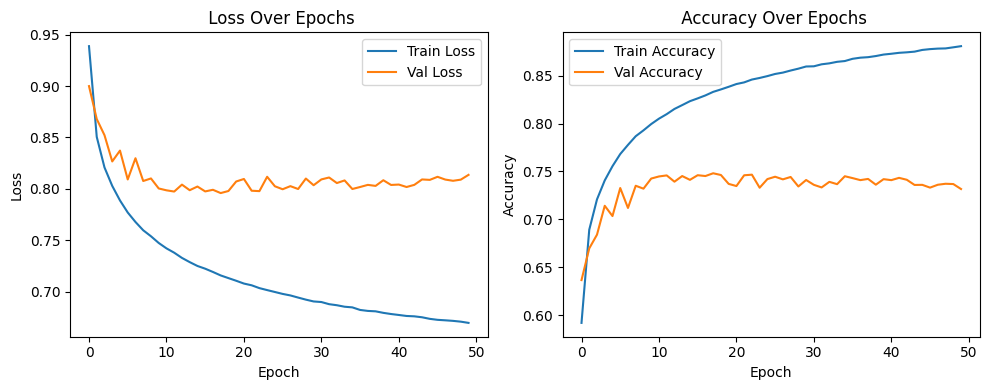

In [7]:
plot_training_history(history)

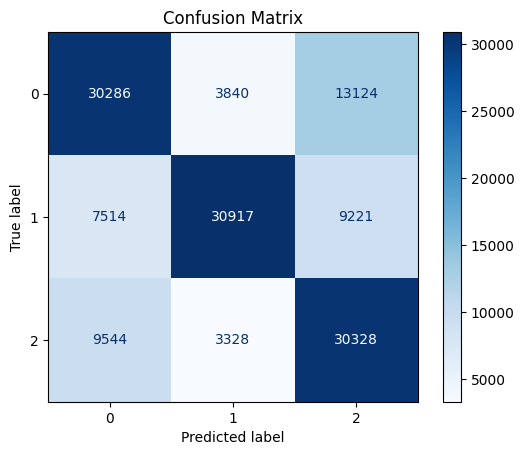

              precision    recall  f1-score   support

           0     0.6397    0.6410    0.6403     47250
           1     0.8118    0.6488    0.7212     47652
           2     0.5758    0.7020    0.6327     43200

    accuracy                         0.6628    138102
   macro avg     0.6758    0.6639    0.6647    138102
weighted avg     0.6791    0.6628    0.6658    138102

Test Accuracy: 0.6628
Test Precision (macro): 0.6758
Test Recall (macro): 0.6639
Test F1 Score (macro): 0.6647


In [23]:
evaluate(model_transLOB, test_loader, device)

In [10]:
epochs = 5
learning_rate = 1e-4

for normalization in ['Zscore','DecPre','MinMax']:
    for k in [0,1,2,3,4]:
        dataset_train, dataset_val, dataset_test = load_fi2010(train_val_ratio, normalization, stock, 
                                                           train_days, test_days, T, k, False)
        if k==0:
            print(f"Training Data Size : {dataset_train.__len__()}")
            print(f"Validation Data Size : {dataset_val.__len__()}")
            print(f"Test Data Size : {dataset_test.__len__()}")
        
        train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        model_transLOB = TransLOB(
            num_features=feature_size,
            num_classes=3,
            hidden_channels=14,
            d_model=15,
            num_heads=3,
            num_transformer_blocks=2
        ).to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model_transLOB.parameters(), lr=learning_rate)
        
        history = train_validate(model_transLOB, train_loader, val_loader, optimizer, criterion, epochs, normalization, k, dataset_type, device)

        

Loading:  Train_Dst_NoAuction_ZScore_CF_7.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_7.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_8.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_9.txt
Training Data Size : 18589
Validation Data Size : 4648
Test Data Size : 6111
Epoch 1/5, Train Loss: 1.0911, Train Acc: 0.3995, Validation Loss: 1.1143, Validation Acc: 0.3079
Epoch 2/5, Train Loss: 1.0892, Train Acc: 0.4023, Validation Loss: 1.1210, Validation Acc: 0.3079
Epoch 3/5, Train Loss: 1.0887, Train Acc: 0.4024, Validation Loss: 1.1135, Validation Acc: 0.3079
Epoch 4/5, Train Loss: 1.0885, Train Acc: 0.4024, Validation Loss: 1.1160, Validation Acc: 0.3079
Epoch 5/5, Train Loss: 1.0886, Train Acc: 0.4024, Validation Loss: 1.1129, Validation Acc: 0.3079
Loading:  Train_Dst_NoAuction_ZScore_CF_7.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_7.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_8.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_9.txt
Epoch 1/5, Train Loss: 1.1014, Train Acc: 0.3380, Validation Loss: 1.10

In [ ]:
### batch - >32
batch_size = 32 
ADAM_B1 = 0.9
ADAM_B2 = 0.999
WEIGHT_DECAY= 1e-5

epochs = 50
learning_rate = 1e-4

for normalization in ['Zscore','DecPre','MinMax']:
    for k in [4]:
        dataset_train, dataset_test = load_fi2010(train_val_ratio, normalization, stock, 
                                                           train_days, test_days, T, k, False)
        if k==4:
            print(f"Training Data Size : {dataset_train.__len__()}")
            print(f"Test Data Size : {dataset_test.__len__()}")
        
        train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)#, num_workers=num_workers)
        test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)#, num_workers=num_workers)

        model_transLOB = TransLOB(
            num_features=feature_size,
            num_classes=3,
            hidden_channels=14,
            d_model=15,
            num_heads=3,
            num_transformer_blocks=2
        ).to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model_transLOB.parameters(), lr=learning_rate, betas=(ADAM_B1, ADAM_B2), weight_decay=WEIGHT_DECAY)

        history = train_validate(model_transLOB, train_loader, test_loader, optimizer, criterion, epochs, normalization, k, dataset_type, device)

Loading:  Train_Dst_NoAuction_ZScore_CF_7.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_7.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_8.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_9.txt


In [6]:
epochs = 50
learning_rate = 1e-4

for normalization in ['Zscore','MinMax','DecPre']:
    for k in [4]: #[0,1,2,3,4]:
        dataset_train, dataset_val, dataset_test = load_fi2010(train_val_ratio, normalization, stock, 
                                                           train_days, test_days, T, k, True)
        if k==4:
            print(f"Training Data Size : {dataset_train.__len__()}")
            print(f"Validation Data Size : {dataset_val.__len__()}")
            print(f"Test Data Size : {dataset_test.__len__()}")
        
        train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)#, num_workers=num_workers)
        val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)#, num_workers=num_workers)
        test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)#, num_workers=num_workers)

        model_deepLOB = Deeplob().to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model_deepLOB.parameters(), lr=learning_rate)

        history = train_validate(model_deepLOB, train_loader, test_loader, optimizer, criterion, epochs, normalization, k, dataset_type, device)

Loading:  Train_Dst_NoAuction_ZScore_CF_7.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_7.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_8.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_9.txt
Training Data Size : 254000
Validation Data Size : 255
Test Data Size : 138102
Epoch 1/50, Train Loss: 0.9431, Train Acc: 0.5821, Validation Loss: 0.8733, Validation Acc: 0.6631
Epoch 2/50, Train Loss: 0.8444, Train Acc: 0.6952, Validation Loss: 0.8503, Validation Acc: 0.6875
Epoch 3/50, Train Loss: 0.8144, Train Acc: 0.7280, Validation Loss: 0.8383, Validation Acc: 0.7010
Epoch 4/50, Train Loss: 0.7962, Train Acc: 0.7477, Validation Loss: 0.8267, Validation Acc: 0.7134
Epoch 5/50, Train Loss: 0.7822, Train Acc: 0.7626, Validation Loss: 0.8253, Validation Acc: 0.7153
Epoch 6/50, Train Loss: 0.7705, Train Acc: 0.7751, Validation Loss: 0.8199, Validation Acc: 0.7220
Epoch 7/50, Train Loss: 0.7618, Train Acc: 0.7844, Validation Loss: 0.8166, Validation Acc: 0.7251
Epoch 8/50, Train Loss: 0.7539, Train Acc: 0.79

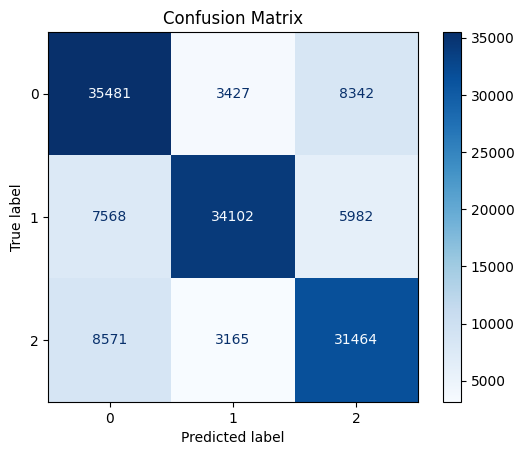

              precision    recall  f1-score   support

           0     0.6873    0.7509    0.7177     47250
           1     0.8380    0.7156    0.7720     47652
           2     0.6872    0.7283    0.7072     43200

    accuracy                         0.7317    138102
   macro avg     0.7375    0.7316    0.7323    138102
weighted avg     0.7393    0.7317    0.7332    138102

Test Accuracy: 0.7317
Test Precision (macro): 0.7375
Test Recall (macro): 0.7316
Test F1 Score (macro): 0.7323


In [10]:
evaluate(model_deepLOB, test_loader, device)

Loading:  Train_Dst_NoAuction_ZScore_CF_7.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_7.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_8.txt
Loading:  Test_Dst_NoAuction_ZScore_CF_9.txt
Training Data Size : 18589
Validation Data Size : 4648
Test Data Size : 6111


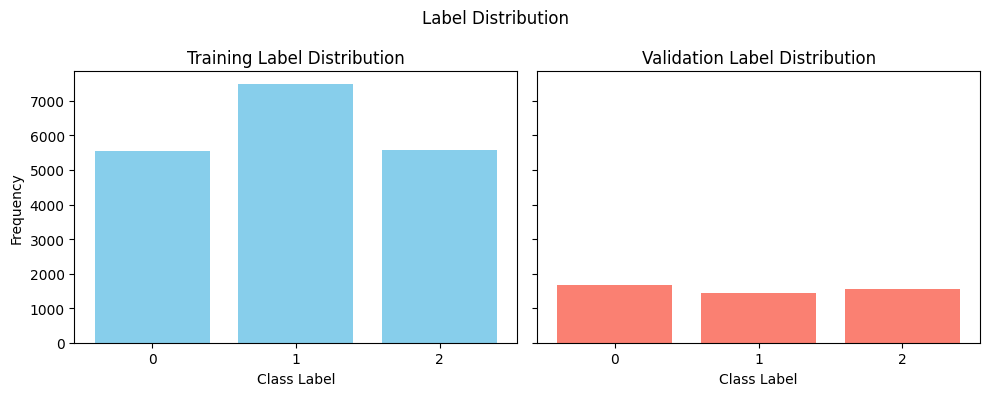

In [15]:
dataset_type='fi2010'
normalization = 'Zscore'
lighten = False
feature_size = 40

T = 100
k = 0
stock = [0]#, 1, 2, 3, 4]
train_val_ratio = 0.8

train_days = [7]
test_days = [8,9,10]

batch_size= 128
num_workers= 4

dataset_train, dataset_val, dataset_test = load_fi2010(train_val_ratio, normalization, stock, 
                                                       train_days, test_days, T, k, True)

print(f"Training Data Size : {dataset_train.__len__()}")
print(f"Validation Data Size : {dataset_val.__len__()}")
print(f"Test Data Size : {dataset_test.__len__()}")

train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

plot_label_distributions(dataset_train, dataset_val)

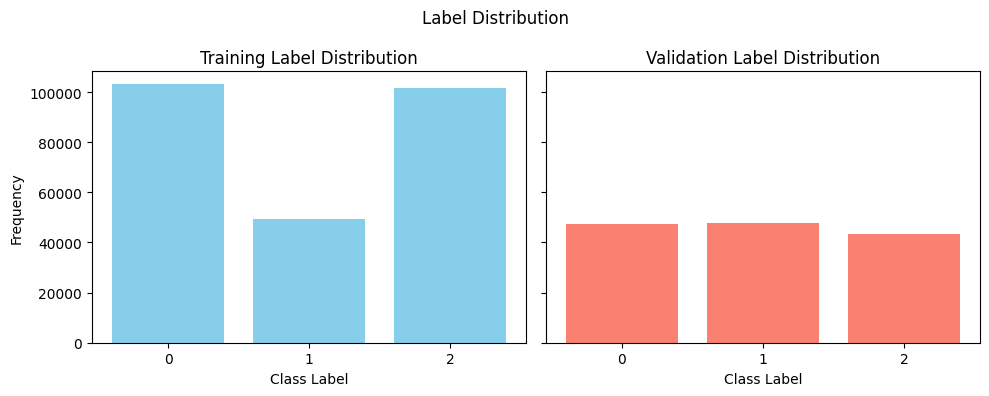

In [25]:
plot_label_distributions(dataset_train, dataset_test)

In [ ]:
# from tqdm import tqdm
# from datetime import datetime

# def batch_gd(model_id, model, criterion, optimizer, train_loader, val_loader, epochs, name):
#     training_info = {
#         'train_loss_hist': [],
#         'val_loss_hist': [],
#         'train_acc_hist': [],
#         'val_acc_hist': []
#     }

#     best_test_loss = np.inf
#     best_test_epoch = 0
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
#     for iter in tqdm(range(epochs)):
#         model.train()
#         t0 = datetime.now()
#         train_loss = []
#         train_acc = []
#         for inputs, targets in tqdm(train_loader):
#             # move data to GPU
#             inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
#             # zero the parameter gradients
#             optimizer.zero_grad()
#             # Forward pass
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             # Backward and optimize
#             loss.backward()
#             optimizer.step()
#             train_loss.append(loss.item())
#             tmp_acc = torch.count_nonzero(torch.argmax(outputs, dim = 1) == targets).item()/targets.size(0)
#             train_acc.append(tmp_acc)
#         # Get train loss and test loss
#         train_loss = np.mean(train_loss)
#         train_acc = np.mean(train_acc)

#         model.eval()
#         val_loss = []
#         val_acc = []
#         for inputs, targets in tqdm(val_loader):
#             inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             val_loss.append(loss.item())
#             tmp_acc = torch.count_nonzero(torch.argmax(outputs, dim=1) == targets).item() / targets.size(0)
#             val_acc.append(tmp_acc)
#         val_loss = np.mean(val_loss)
#         val_acc = np.mean(val_acc)

#         # Save losses
#         training_info['train_loss_hist'].append(train_loss)
#         training_info['val_loss_hist'].append(val_loss)
#         training_info['train_acc_hist'].append(train_acc)
#         training_info['val_acc_hist'].append(val_acc)

#         if val_loss < best_test_loss:
#             # torch.save(model, os.path.join(logger.find_save_path(model_id), 'best_val_model.pt'))
#             best_test_loss = val_loss
#             best_test_epoch = iter
#             print('model saved')

#         dt = datetime.now() - t0
#         print(f'Epoch {iter + 1}/{epochs}, '
#               f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc: .4f}, '
#               f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc: .4f}, '
#               f'Duration: {dt}, Best Val Epoch: {best_test_epoch}')

#     # torch.save({
#     #     'epoch': epochs,
#     #     'model_state_dict': model.state_dict(),
#     #     'optimizer_state_dict': optimizer.state_dict(),
#     #     'loss': train_loss,
#     # }, os.path.join(logger.find_save_path(model_id), 'checkpoint.pt'))

#     # with open(os.path.join(logger.find_save_path(model_id), 'training_process.pkl'), 'wb') as f:
#     #     pickle.dump(training_info, f)

#     return


In [ ]:
# model_transLOB.eval()

# all_y_true = []
# all_y_pred = []

# with torch.no_grad():
#     for X_batch, y_batch in val_loader:
#         X_batch, y_batch = X_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.int64) 
#         # X_batch, y_batch = X_batch.to(device), y_batch.to(device)

#         outputs = model_transLOB(X_batch)
#         _, y_pred = outputs.max(1)

#         all_y_true.append(y_batch.cpu().numpy())
#         all_y_pred.append(y_pred.cpu().numpy())

# all_y_true = np.concatenate(all_y_true)
# all_y_pred = np.concatenate(all_y_pred)

# cm = confusion_matrix(all_y_true, all_y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap="Blues", values_format="d")
# plt.title("Confusion Matrix on Test Set")
# plt.show()

# accuracy = accuracy_score(all_y_true, all_y_pred)
# precision = precision_score(all_y_true, all_y_pred, average='macro')
# recall = recall_score(all_y_true, all_y_pred, average='macro')
# f1 = f1_score(all_y_true, all_y_pred, average='macro')

# print(classification_report(all_y_true, all_y_pred, digits=4))

# print(f"Test Accuracy: {accuracy:.4f}")
# print(f"Test Precision (macro): {precision:.4f}")
# print(f"Test Recall (macro): {recall:.4f}")
# print(f"Test F1 Score (macro): {f1:.4f}")

In [ ]:
# from utils.training import train, validate, train_validate




# train_losses = []
# train_accuracies = []
# val_losses = []
# val_accuracies = []

# best_val_acc = 0

# for epoch in range(epochs):
#     train_loss, train_acc = train(model_transLOB, train_loader, optimizer, criterion, device)
#     val_loss, val_acc = validate(model_transLOB, val_loader, criterion, device)
#     # val_loss, val_acc = validate(model, val_loader, criterion, device)

#     train_losses.append(train_loss)
#     train_accuracies.append(train_acc)
#     val_losses.append(val_loss)
#     val_accuracies.append(val_acc)

#     print(f"Epoch {epoch+1}/{epochs}: "
#           f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | "
#           f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

#     # Save best model
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         torch.save(model_transLOB.state_dict(), './outputs/transLOB/best_transLOB_fi2010.pth')
#         print(f"✅ Saved best model at epoch {epoch+1} with Val Acc {val_acc:.4f}")